In [1]:
import dtale
import pandas as pd

import numpy as np
import seaborn as sns
from scipy.stats import ks_2samp
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE

from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import train_test_split

from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.metrics import f1_score, roc_auc_score, classification_report, confusion_matrix
from sklearn.metrics import roc_curve, precision_recall_curve

metrics_data_columns = ['k_neighbour', 'test_accuracy', 'train_accuracy', 
                         'precision_0', 'recall_0', 'f1_0',
                         'precision_1', 'recall_1', 'f1_1', 
                         'roc_auc', 'ks_stat', 'p_value', 
                         'tp', 'tn', 'fp', 'fn']

### Reading data

In [2]:
# Reading data
data_loc = "./Churn_Modelling.csv"
df = pd.read_csv(data_loc, index_col=0)
df.head()

,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
RowNumber,,,,,,,,,,,,,
1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 1 to 10000
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   CustomerId       10000 non-null  int64  
 1   Surname          10000 non-null  object 
 2   CreditScore      10000 non-null  int64  
 3   Geography        10000 non-null  object 
 4   Gender           10000 non-null  object 
 5   Age              10000 non-null  int64  
 6   Tenure           10000 non-null  int64  
 7   Balance          10000 non-null  float64
 8   NumOfProducts    10000 non-null  int64  
 9   HasCrCard        10000 non-null  int64  
 10  IsActiveMember   10000 non-null  int64  
 11  EstimatedSalary  10000 non-null  float64
 12  Exited           10000 non-null  int64  
dtypes: float64(2), int64(8), object(3)
memory usage: 1.1+ MB


In [4]:
df.describe()

,CustomerId,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000
mean,1.569094e+07,650.528800,38.921800,5.012800,76485.889288,1.530200,0.70550,0.515100,100090.239881,0.203700
std,7.193619e+04,96.653299,10.487806,2.892174,62397.405202,0.581654,0.45584,0.499797,57510.492818,0.402769
min,1.556570e+07,350.000000,18.000000,0.000000,0.000000,1.000000,0.00000,0.000000,11.580000,0.000000
25%,1.562853e+07,584.000000,32.000000,3.000000,0.000000,1.000000,0.00000,0.000000,51002.110000,0.000000
50%,1.569074e+07,652.000000,37.000000,5.000000,97198.540000,1.000000,1.00000,1.000000,100193.915000,0.000000
75%,1.575323e+07,718.000000,44.000000,7.000000,127644.240000,2.000000,1.00000,1.000000,149388.247500,0.000000
max,1.581569e+07,850.000000,92.000000,10.000000,250898.090000,4.000000,1.00000,1.000000,199992.480000,1.000000


## Unique values in each column

In [5]:
for idx,column in enumerate(df.columns):
    unique_values = df[column].unique()
    print("{}. {:<20} :: Unique value count :: {:<10}".format(idx,column, len(unique_values)), end='')
    if len(unique_values) < 15:
        print(f" :: {sorted(unique_values)}")
    else:
        print()

0. CustomerId           :: Unique value count :: 10000     
1. Surname              :: Unique value count :: 2932      
2. CreditScore          :: Unique value count :: 460       
3. Geography            :: Unique value count :: 3          :: ['France', 'Germany', 'Spain']
4. Gender               :: Unique value count :: 2          :: ['Female', 'Male']
5. Age                  :: Unique value count :: 70        
6. Tenure               :: Unique value count :: 11         :: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
7. Balance              :: Unique value count :: 6382      
8. NumOfProducts        :: Unique value count :: 4          :: [1, 2, 3, 4]
9. HasCrCard            :: Unique value count :: 2          :: [0, 1]
10. IsActiveMember       :: Unique value count :: 2          :: [0, 1]
11. EstimatedSalary      :: Unique value count :: 9999      
12. Exited               :: Unique value count :: 2          :: [0, 1]


# Basic understanding about dataset

- RowNumber: the index of the row in the dataset
- CustomerId: a unique identifier for each customer
- CreditScore: the customer's credit score
- Age: the customer's age
- Tenure: the number of years the customer has been with the bank
- Balance: the customer's account balance
- NumOfProducts: the number of bank products the customer has
- HasCrCard: whether the customer has a credit card with the bank (1=yes, 0=no)
- IsActiveMember: whether the customer is an active member of the bank (1=yes, 0=no)
- EstimatedSalary: the customer's estimated salary
- Exited: whether the customer has churned (left the bank) (1=yes, 0=no)

## Class Distribution

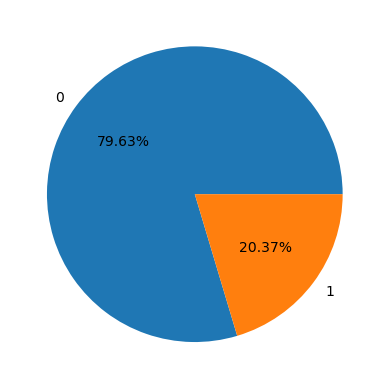

In [6]:
plt.pie(df["Exited"].value_counts(), 
        labels=sorted(df['Exited'].unique()),
        autopct='%1.2f%%')
plt.show()

## Correlation Matrix

<Axes: >

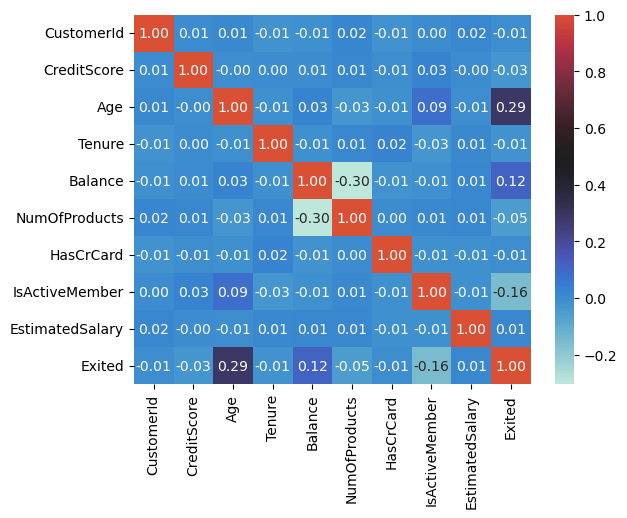

In [7]:
sns.heatmap(df[df.describe().columns].corr(),
            annot=True,
            fmt='.2f',
            center=0.5)

### Drop all categorical columns

In [3]:
df.drop(['CustomerId', 'Surname','Geography', 'Gender'], axis = 1,inplace=True)
df

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
RowNumber,,,,,,,,,
1,619,42,2,0.00,1,1,1,101348.88,1
2,608,41,1,83807.86,1,0,1,112542.58,0
3,502,42,8,159660.80,3,1,0,113931.57,1
4,699,39,1,0.00,2,0,0,93826.63,0
5,850,43,2,125510.82,1,1,1,79084.10,0
...,...,...,...,...,...,...,...,...,...
9996,771,39,5,0.00,2,1,0,96270.64,0
9997,516,35,10,57369.61,1,1,1,101699.77,0
9998,709,36,7,0.00,1,0,1,42085.58,1


## Base Logistic Regression model

In [4]:
## Train test split

x = df.drop('Exited', axis=1)
y = df['Exited']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42, stratify=df['Exited'])
# train, test = train_test_split(df, train_size=0.8, random_state=42, stratify=df.Exited)

# x_train = train[['CreditScore', 'Age', 'Tenure', 
#                  'Balance', 'NumOfProducts', 'HasCrCard',
#                  'IsActiveMember', 'EstimatedSalary']]
# y_train = train['Exited']

# x_test = test[['CreditScore', 'Age', 'Tenure', 
#                  'Balance', 'NumOfProducts', 'HasCrCard',
#                  'IsActiveMember', 'EstimatedSalary']]
# y_test = test['Exited']

print("Shape of x train :: ", x_train.shape)
print("Shape of y train :: ", y_train.shape)
print("Shape of x test :: ", x_test.shape)
print("Shape of y test :: ", y_test.shape)

log_reg_model = LogisticRegression(random_state=42, max_iter=1000)
log_reg_model.fit(x_train, y_train)

## Prediction
y_pred = log_reg_model.predict(x_test)

Shape of x train ::  (8000, 8)
Shape of y train ::  (8000,)
Shape of x test ::  (2000, 8)
Shape of y test ::  (2000,)


In [5]:

# Evaluate the model

test_accuracy = round(accuracy_score(y_test, y_pred), ndigits=4)

# For class 0
precision_0 = round(precision_score(y_test, y_pred,pos_label=0), ndigits=4)
recall_0 = round(recall_score(y_test, y_pred,pos_label=0), ndigits=4)
f1_0 = round(f1_score(y_test, y_pred, pos_label=0), ndigits=4)

# For class 1
precision_1 = round(precision_score(y_test, y_pred,pos_label=1), ndigits=4)
recall_1 = round(recall_score(y_test, y_pred,pos_label=1), ndigits=4)
f1_1 = round(f1_score(y_test, y_pred, pos_label=1), ndigits=4)

# ROC
roc_auc = round(roc_auc_score(y_test, y_pred), ndigits=4)

# Calculate true positives, true negatives, false positives, false negatives
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()


# Perform the Kolmogorov-Smirnov test
# ks_stat, p_value = ks_2samp(y_test[y_pred == 0], y_test[y_pred == 1])
# ks_stat = round(ks_stat, ndigits=4)

y_pred_train = log_reg_model.predict(x_train)
train_accuracy = round(accuracy_score(y_train, y_pred_train), ndigits=4)

# metrics_data.append([neighbour, test_accuracy, train_accuracy, precision, recall, 
#                      f1, roc_auc, ks_stat, p_value, 
#                      tp, tn, fp, fn])

# Print the evaluation metrics
print(f"Test Accuracy: {test_accuracy} :: Train Accuracy: {train_accuracy}")
print()

print("Precision for class 0:", precision_0)
print("Recall for class 0:", recall_0)
print("F1 Score for class 0:", f1_0)
print()

print("Precision for class 1:", precision_1)
print("Recall for class 1:", recall_1)
print("F1 Score for class 1:", f1_1)
print()

print("ROC AUC Score:", roc_auc)
print()

# Print the KS statistic and p-value
# print("Kolmogorov-Smirnov Test:")
# print("KS statistic:", ks_stat)
# print("p-value:", p_value)
# print()


# Print the calculated values
print("True Positives:", tp)
print("True Negatives:", tn)
print("False Positives:", fp)
print("False Negatives:", fn)
print()

# Print the classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))

Test Accuracy: 0.7965 :: Train Accuracy: 0.7962

Precision for class 0: 0.7965
Recall for class 0: 1.0
F1 Score for class 0: 0.8867

Precision for class 1: 0.0
Recall for class 1: 0.0
F1 Score for class 1: 0.0

ROC AUC Score: 0.5

True Positives: 0
True Negatives: 1593
False Positives: 0
False Negatives: 407

Classification Report:
              precision    recall  f1-score   support

           0       0.80      1.00      0.89      1593
           1       0.00      0.00      0.00       407

    accuracy                           0.80      2000
   macro avg       0.40      0.50      0.44      2000
weighted avg       0.63      0.80      0.71      2000



/home/growlt200/anaconda3/envs/aml/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.

/home/growlt200/anaconda3/envs/aml/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/home/growlt200/anaconda3/envs/aml/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/home/growlt200/anaconda3/envs/aml/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and bein

In [40]:
# This is the classification report i get when without stratify

# Classification Report:
#               precision    recall  f1-score

#            0       0.81      0.98      0.89
#            1       0.45      0.07      0.12
        
# This is the classification report i get when with stratify

# Classification Report:
#               precision    recall  f1-score

#            0       0.80      1.00      0.89
#            1       0.00      0.00      0.00


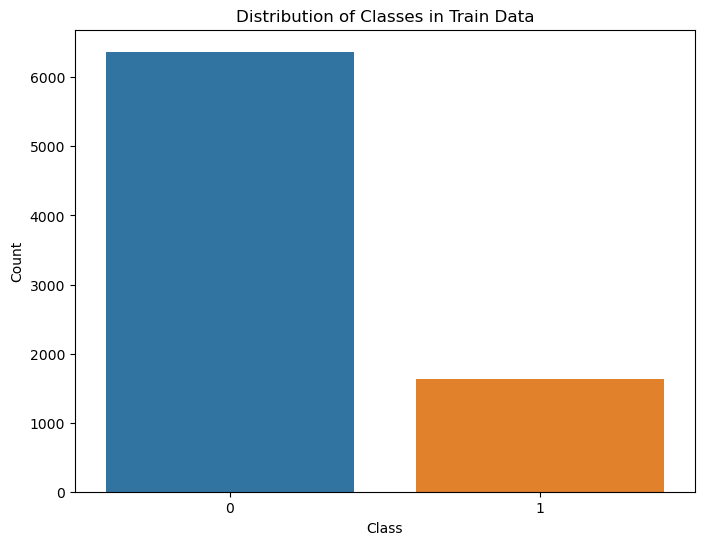

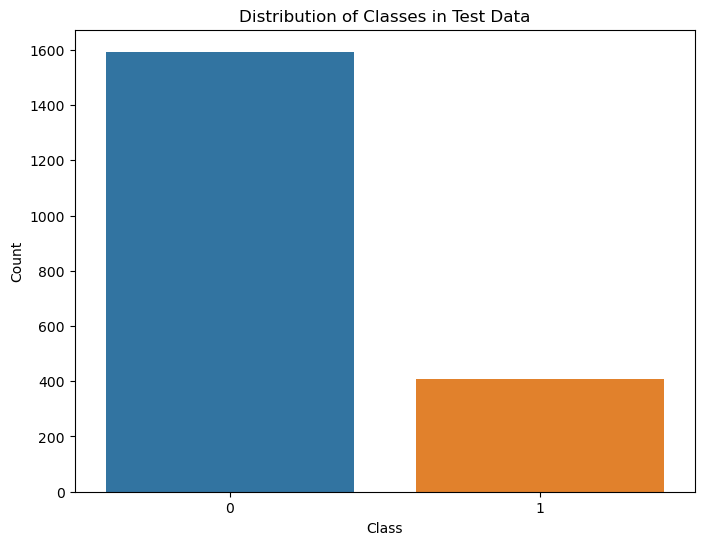

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot the distribution of classes in the train data
plt.figure(figsize=(8, 6))
sns.countplot(x=y_train)
plt.title('Distribution of Classes in Train Data')
plt.xlabel('Class')
plt.ylabel('Count')
plt.show()

# Plot the distribution of classes in the test data
plt.figure(figsize=(8, 6))
sns.countplot(x=y_test)
plt.title('Distribution of Classes in Test Data')
plt.xlabel('Class')
plt.ylabel('Count')
plt.show()


## SMOTE method

### Apply using two different approach::
    1. On whole dataset [before train, test split] [APPROACH 1]
    2. Only on train data [after train, test split] [APPROACH 2]

### APPROACH 1

In [7]:
metrics_data_columns = ['k_neighbour', 'test_accuracy', 'train_accuracy', 
                         'precision_0', 'recall_0', 'f1_0',
                         'precision_1', 'recall_1', 'f1_1', 
                         'roc_auc', 'ks_stat', 'p_value', 
                         'tp', 'tn', 'fp', 'fn']

In [4]:
### In loop

metrics_data = []

for neighbour in range(1,2037):

    ## APPLY SMOTE

    x = df.drop('Exited', axis=1)
    y = df['Exited']

    # Apply SMOTE
    sm = SMOTE(random_state=42, k_neighbors=neighbour)

    x_new, y_new = sm.fit_resample(x,y)

    # Print the class distribution before and after SMOTE
    # print('Class distribution before SMOTE:\n', y.value_counts())
    # print('Class distribution after SMOTE:\n', y_new.value_counts())

    df_new = pd.concat([x_new, y_new], axis=1)
    
    train, test = train_test_split(df_new, train_size=0.8, random_state=42, stratify=df_new.Exited)
    
    x_train = train[['CreditScore', 'Age', 'Tenure', 
                     'Balance', 'NumOfProducts', 'HasCrCard',
                     'IsActiveMember', 'EstimatedSalary']]
    y_train = train['Exited']
    
    x_test = test[['CreditScore', 'Age', 'Tenure', 
                     'Balance', 'NumOfProducts', 'HasCrCard',
                     'IsActiveMember', 'EstimatedSalary']]
    y_test = test['Exited']

#     ## Train test split
#     x = df_new.drop('Exited', axis=1)
#     y = df_new['Exited']

#     x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42, 
#                                                         stratify=df_new['Exited'])
    # print("Shape of x train :: ", x_train.shape)
    # print("Shape of y train :: ", y_train.shape)
    # print("Shape of x test :: ", x_test.shape)
    # print("Shape of y test :: ", y_test.shape)

    ## TRAIN LOGSTIC REGRESSION
    from sklearn.linear_model import LogisticRegression

    log_reg_model = LogisticRegression(random_state=42, max_iter=1000)
    log_reg_model.fit(x_train, y_train)

    ## Prediction
    y_pred = log_reg_model.predict(x_test)

    # Evaluate the model

    test_accuracy = round(accuracy_score(y_test, y_pred), ndigits=4)

    # For class 0
    precision_0 = round(precision_score(y_test, y_pred,pos_label=0), ndigits=4)
    recall_0 = round(recall_score(y_test, y_pred,pos_label=0), ndigits=4)
    f1_0 = round(f1_score(y_test, y_pred, pos_label=0), ndigits=4)

    # For class 1
    precision_1 = round(precision_score(y_test, y_pred,pos_label=1), ndigits=4)
    recall_1 = round(recall_score(y_test, y_pred,pos_label=1), ndigits=4)
    f1_1 = round(f1_score(y_test, y_pred, pos_label=1), ndigits=4)

    # ROC
    roc_auc = round(roc_auc_score(y_test, y_pred), ndigits=4)

    # Calculate true positives, true negatives, false positives, false negatives
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()


    # Perform the Kolmogorov-Smirnov test
    ks_stat, p_value = ks_2samp(y_test[y_pred == 0], y_test[y_pred == 1])
    ks_stat = round(ks_stat, ndigits=4)
    p_value = round(p_value, ndigits=4)

    y_pred_train = log_reg_model.predict(x_train)
    train_accuracy = round(accuracy_score(y_train, y_pred_train), ndigits=4)

    metrics_data.append([neighbour, test_accuracy, train_accuracy, 
                         precision_0, recall_0, f1_0,
                         precision_1, recall_1, f1_1, 
                         roc_auc, ks_stat, p_value, 
                         tp, tn, fp, fn])

    # Print the evaluation metrics
    print(f"{neighbour} :: Test Accuracy: {test_accuracy} :: Train Accuracy: {train_accuracy}")
#     print()

#     print("Precision for class 0:", precision_0)
#     print("Recall for class 0:", recall_0)
#     print("F1 Score for class 0:", f1_0)
#     print()

#     print("Precision for class 1:", precision_1)
#     print("Recall for class 1:", recall_1)
#     print("F1 Score for class 1:", f1_1)
#     print()

#     print("ROC AUC Score:", roc_auc)
#     print()

#     # Print the KS statistic and p-value
#     print("Kolmogorov-Smirnov Test:")
#     print("KS statistic:", ks_stat)
#     print("p-value:", p_value)
#     print()


#     # Print the calculated values
#     print("True Positives:", tp)
#     print("True Negatives:", tn)
#     print("False Positives:", fp)
#     print("False Negatives:", fn)
#     print()

#     # Print the classification report
#     print("Classification Report:")
#     print(classification_report(y_test, y_pred))

#     break


1 :: Test Accuracy: 0.6791 :: Train Accuracy: 0.6723
2 :: Test Accuracy: 0.6738 :: Train Accuracy: 0.6759
3 :: Test Accuracy: 0.6625 :: Train Accuracy: 0.6682
4 :: Test Accuracy: 0.6797 :: Train Accuracy: 0.6729
5 :: Test Accuracy: 0.6769 :: Train Accuracy: 0.6715
6 :: Test Accuracy: 0.6769 :: Train Accuracy: 0.6664
7 :: Test Accuracy: 0.6732 :: Train Accuracy: 0.6747
8 :: Test Accuracy: 0.6722 :: Train Accuracy: 0.6715
9 :: Test Accuracy: 0.6597 :: Train Accuracy: 0.6696
10 :: Test Accuracy: 0.6735 :: Train Accuracy: 0.6683
11 :: Test Accuracy: 0.6813 :: Train Accuracy: 0.6703
12 :: Test Accuracy: 0.6732 :: Train Accuracy: 0.6628
13 :: Test Accuracy: 0.6738 :: Train Accuracy: 0.6667
14 :: Test Accuracy: 0.6779 :: Train Accuracy: 0.6659
15 :: Test Accuracy: 0.6741 :: Train Accuracy: 0.6704
16 :: Test Accuracy: 0.6763 :: Train Accuracy: 0.6737
17 :: Test Accuracy: 0.5799 :: Train Accuracy: 0.5665
18 :: Test Accuracy: 0.6851 :: Train Accuracy: 0.6776
19 :: Test Accuracy: 0.6688 :: Train 

154 :: Test Accuracy: 0.681 :: Train Accuracy: 0.6659
155 :: Test Accuracy: 0.6697 :: Train Accuracy: 0.6613
156 :: Test Accuracy: 0.6716 :: Train Accuracy: 0.6673
157 :: Test Accuracy: 0.6791 :: Train Accuracy: 0.6753
158 :: Test Accuracy: 0.675 :: Train Accuracy: 0.6757
159 :: Test Accuracy: 0.6744 :: Train Accuracy: 0.6693
160 :: Test Accuracy: 0.6763 :: Train Accuracy: 0.6723
161 :: Test Accuracy: 0.6728 :: Train Accuracy: 0.6684
162 :: Test Accuracy: 0.6691 :: Train Accuracy: 0.674
163 :: Test Accuracy: 0.6728 :: Train Accuracy: 0.6648
164 :: Test Accuracy: 0.671 :: Train Accuracy: 0.6639
165 :: Test Accuracy: 0.6669 :: Train Accuracy: 0.674
166 :: Test Accuracy: 0.7476 :: Train Accuracy: 0.7502
167 :: Test Accuracy: 0.67 :: Train Accuracy: 0.6675
168 :: Test Accuracy: 0.6728 :: Train Accuracy: 0.6756
169 :: Test Accuracy: 0.6688 :: Train Accuracy: 0.6625
170 :: Test Accuracy: 0.6735 :: Train Accuracy: 0.6717
171 :: Test Accuracy: 0.6694 :: Train Accuracy: 0.6678
172 :: Test Accur

304 :: Test Accuracy: 0.6713 :: Train Accuracy: 0.6657
305 :: Test Accuracy: 0.6772 :: Train Accuracy: 0.673
306 :: Test Accuracy: 0.6722 :: Train Accuracy: 0.6726
307 :: Test Accuracy: 0.6694 :: Train Accuracy: 0.6613
308 :: Test Accuracy: 0.6797 :: Train Accuracy: 0.6689
309 :: Test Accuracy: 0.6644 :: Train Accuracy: 0.6652
310 :: Test Accuracy: 0.6716 :: Train Accuracy: 0.6743
311 :: Test Accuracy: 0.6823 :: Train Accuracy: 0.665
312 :: Test Accuracy: 0.6741 :: Train Accuracy: 0.6627
313 :: Test Accuracy: 0.6684 :: Train Accuracy: 0.668
314 :: Test Accuracy: 0.7435 :: Train Accuracy: 0.7444
315 :: Test Accuracy: 0.6662 :: Train Accuracy: 0.6642
316 :: Test Accuracy: 0.6785 :: Train Accuracy: 0.6664
317 :: Test Accuracy: 0.6732 :: Train Accuracy: 0.6734
318 :: Test Accuracy: 0.6669 :: Train Accuracy: 0.665
319 :: Test Accuracy: 0.6725 :: Train Accuracy: 0.6755
320 :: Test Accuracy: 0.6747 :: Train Accuracy: 0.672
321 :: Test Accuracy: 0.6722 :: Train Accuracy: 0.6656
322 :: Test Acc

455 :: Test Accuracy: 0.6785 :: Train Accuracy: 0.6776
456 :: Test Accuracy: 0.6776 :: Train Accuracy: 0.6675
457 :: Test Accuracy: 0.675 :: Train Accuracy: 0.6663
458 :: Test Accuracy: 0.6807 :: Train Accuracy: 0.6637
459 :: Test Accuracy: 0.6851 :: Train Accuracy: 0.6649
460 :: Test Accuracy: 0.6779 :: Train Accuracy: 0.6741
461 :: Test Accuracy: 0.6794 :: Train Accuracy: 0.6742
462 :: Test Accuracy: 0.6763 :: Train Accuracy: 0.6749
463 :: Test Accuracy: 0.6788 :: Train Accuracy: 0.6659
464 :: Test Accuracy: 0.6779 :: Train Accuracy: 0.6762
465 :: Test Accuracy: 0.686 :: Train Accuracy: 0.6641
466 :: Test Accuracy: 0.675 :: Train Accuracy: 0.6665
467 :: Test Accuracy: 0.6725 :: Train Accuracy: 0.6695
468 :: Test Accuracy: 0.6659 :: Train Accuracy: 0.6679
469 :: Test Accuracy: 0.6716 :: Train Accuracy: 0.6676
470 :: Test Accuracy: 0.6769 :: Train Accuracy: 0.6685
471 :: Test Accuracy: 0.6754 :: Train Accuracy: 0.6679
472 :: Test Accuracy: 0.6826 :: Train Accuracy: 0.6657
473 :: Test A

606 :: Test Accuracy: 0.6754 :: Train Accuracy: 0.6692
607 :: Test Accuracy: 0.675 :: Train Accuracy: 0.6645
608 :: Test Accuracy: 0.6779 :: Train Accuracy: 0.673
609 :: Test Accuracy: 0.6647 :: Train Accuracy: 0.6686
610 :: Test Accuracy: 0.676 :: Train Accuracy: 0.666
611 :: Test Accuracy: 0.6656 :: Train Accuracy: 0.6673
612 :: Test Accuracy: 0.6678 :: Train Accuracy: 0.6766
613 :: Test Accuracy: 0.675 :: Train Accuracy: 0.6667
614 :: Test Accuracy: 0.6779 :: Train Accuracy: 0.6607
615 :: Test Accuracy: 0.6772 :: Train Accuracy: 0.6689
616 :: Test Accuracy: 0.6816 :: Train Accuracy: 0.6728
617 :: Test Accuracy: 0.6813 :: Train Accuracy: 0.6678
618 :: Test Accuracy: 0.6688 :: Train Accuracy: 0.6711
619 :: Test Accuracy: 0.6779 :: Train Accuracy: 0.6721
620 :: Test Accuracy: 0.6885 :: Train Accuracy: 0.668
621 :: Test Accuracy: 0.6823 :: Train Accuracy: 0.6695
622 :: Test Accuracy: 0.6832 :: Train Accuracy: 0.6716
623 :: Test Accuracy: 0.6722 :: Train Accuracy: 0.6709
624 :: Test Accu

756 :: Test Accuracy: 0.6744 :: Train Accuracy: 0.6729
757 :: Test Accuracy: 0.6791 :: Train Accuracy: 0.6714
758 :: Test Accuracy: 0.6829 :: Train Accuracy: 0.6694
759 :: Test Accuracy: 0.6782 :: Train Accuracy: 0.6686
760 :: Test Accuracy: 0.6788 :: Train Accuracy: 0.669
761 :: Test Accuracy: 0.7491 :: Train Accuracy: 0.7454
762 :: Test Accuracy: 0.6785 :: Train Accuracy: 0.6703
763 :: Test Accuracy: 0.6819 :: Train Accuracy: 0.6722
764 :: Test Accuracy: 0.6838 :: Train Accuracy: 0.67
765 :: Test Accuracy: 0.676 :: Train Accuracy: 0.6664
766 :: Test Accuracy: 0.6716 :: Train Accuracy: 0.6682
767 :: Test Accuracy: 0.6719 :: Train Accuracy: 0.6714
768 :: Test Accuracy: 0.6797 :: Train Accuracy: 0.6683
769 :: Test Accuracy: 0.6816 :: Train Accuracy: 0.668
770 :: Test Accuracy: 0.6776 :: Train Accuracy: 0.6702
771 :: Test Accuracy: 0.6794 :: Train Accuracy: 0.6686
772 :: Test Accuracy: 0.6713 :: Train Accuracy: 0.6704
773 :: Test Accuracy: 0.6769 :: Train Accuracy: 0.677
774 :: Test Accu

906 :: Test Accuracy: 0.6835 :: Train Accuracy: 0.6686
907 :: Test Accuracy: 0.6766 :: Train Accuracy: 0.6669
908 :: Test Accuracy: 0.686 :: Train Accuracy: 0.67
909 :: Test Accuracy: 0.676 :: Train Accuracy: 0.6762
910 :: Test Accuracy: 0.6791 :: Train Accuracy: 0.6726
911 :: Test Accuracy: 0.6845 :: Train Accuracy: 0.6692
912 :: Test Accuracy: 0.671 :: Train Accuracy: 0.6704
913 :: Test Accuracy: 0.6832 :: Train Accuracy: 0.6693
914 :: Test Accuracy: 0.6801 :: Train Accuracy: 0.6729
915 :: Test Accuracy: 0.5906 :: Train Accuracy: 0.586
916 :: Test Accuracy: 0.6741 :: Train Accuracy: 0.6708
917 :: Test Accuracy: 0.6826 :: Train Accuracy: 0.6711
918 :: Test Accuracy: 0.5887 :: Train Accuracy: 0.5824
919 :: Test Accuracy: 0.686 :: Train Accuracy: 0.6704
920 :: Test Accuracy: 0.5824 :: Train Accuracy: 0.5861
921 :: Test Accuracy: 0.6857 :: Train Accuracy: 0.6677
922 :: Test Accuracy: 0.6788 :: Train Accuracy: 0.6678
923 :: Test Accuracy: 0.671 :: Train Accuracy: 0.6755
924 :: Test Accura

1055 :: Test Accuracy: 0.6819 :: Train Accuracy: 0.6668
1056 :: Test Accuracy: 0.6747 :: Train Accuracy: 0.6691
1057 :: Test Accuracy: 0.671 :: Train Accuracy: 0.6689
1058 :: Test Accuracy: 0.6744 :: Train Accuracy: 0.6769
1059 :: Test Accuracy: 0.675 :: Train Accuracy: 0.6702
1060 :: Test Accuracy: 0.5918 :: Train Accuracy: 0.5858
1061 :: Test Accuracy: 0.6716 :: Train Accuracy: 0.6675
1062 :: Test Accuracy: 0.6813 :: Train Accuracy: 0.6667
1063 :: Test Accuracy: 0.6782 :: Train Accuracy: 0.6678
1064 :: Test Accuracy: 0.6813 :: Train Accuracy: 0.6716
1065 :: Test Accuracy: 0.6688 :: Train Accuracy: 0.6686
1066 :: Test Accuracy: 0.6807 :: Train Accuracy: 0.6694
1067 :: Test Accuracy: 0.675 :: Train Accuracy: 0.6709
1068 :: Test Accuracy: 0.6735 :: Train Accuracy: 0.6733
1069 :: Test Accuracy: 0.6757 :: Train Accuracy: 0.672
1070 :: Test Accuracy: 0.6804 :: Train Accuracy: 0.6679
1071 :: Test Accuracy: 0.6782 :: Train Accuracy: 0.674
1072 :: Test Accuracy: 0.681 :: Train Accuracy: 0.666

1203 :: Test Accuracy: 0.6766 :: Train Accuracy: 0.6704
1204 :: Test Accuracy: 0.6779 :: Train Accuracy: 0.6664
1205 :: Test Accuracy: 0.6788 :: Train Accuracy: 0.6646
1206 :: Test Accuracy: 0.6801 :: Train Accuracy: 0.6723
1207 :: Test Accuracy: 0.6782 :: Train Accuracy: 0.6686
1208 :: Test Accuracy: 0.6772 :: Train Accuracy: 0.6675
1209 :: Test Accuracy: 0.6838 :: Train Accuracy: 0.6693
1210 :: Test Accuracy: 0.686 :: Train Accuracy: 0.6676
1211 :: Test Accuracy: 0.6845 :: Train Accuracy: 0.6718
1212 :: Test Accuracy: 0.6779 :: Train Accuracy: 0.6722
1213 :: Test Accuracy: 0.6776 :: Train Accuracy: 0.6723
1214 :: Test Accuracy: 0.6754 :: Train Accuracy: 0.6698
1215 :: Test Accuracy: 0.6754 :: Train Accuracy: 0.6668
1216 :: Test Accuracy: 0.6766 :: Train Accuracy: 0.6704
1217 :: Test Accuracy: 0.6785 :: Train Accuracy: 0.6678
1218 :: Test Accuracy: 0.5909 :: Train Accuracy: 0.5835
1219 :: Test Accuracy: 0.6713 :: Train Accuracy: 0.6697
1220 :: Test Accuracy: 0.6776 :: Train Accuracy: 

1351 :: Test Accuracy: 0.6779 :: Train Accuracy: 0.6679
1352 :: Test Accuracy: 0.675 :: Train Accuracy: 0.6715
1353 :: Test Accuracy: 0.6772 :: Train Accuracy: 0.6731
1354 :: Test Accuracy: 0.5808 :: Train Accuracy: 0.5788
1355 :: Test Accuracy: 0.676 :: Train Accuracy: 0.6717
1356 :: Test Accuracy: 0.6732 :: Train Accuracy: 0.6678
1357 :: Test Accuracy: 0.6848 :: Train Accuracy: 0.6691
1358 :: Test Accuracy: 0.681 :: Train Accuracy: 0.6702
1359 :: Test Accuracy: 0.6782 :: Train Accuracy: 0.6659
1360 :: Test Accuracy: 0.6728 :: Train Accuracy: 0.6653
1361 :: Test Accuracy: 0.6794 :: Train Accuracy: 0.6696
1362 :: Test Accuracy: 0.6694 :: Train Accuracy: 0.6742
1363 :: Test Accuracy: 0.5818 :: Train Accuracy: 0.5861
1364 :: Test Accuracy: 0.676 :: Train Accuracy: 0.679
1365 :: Test Accuracy: 0.6785 :: Train Accuracy: 0.6715
1366 :: Test Accuracy: 0.6757 :: Train Accuracy: 0.6703
1367 :: Test Accuracy: 0.6757 :: Train Accuracy: 0.679
1368 :: Test Accuracy: 0.6816 :: Train Accuracy: 0.666

1498 :: Test Accuracy: 0.6757 :: Train Accuracy: 0.6659
1499 :: Test Accuracy: 0.6763 :: Train Accuracy: 0.6697
1500 :: Test Accuracy: 0.6684 :: Train Accuracy: 0.6682
1501 :: Test Accuracy: 0.6832 :: Train Accuracy: 0.6671
1502 :: Test Accuracy: 0.6769 :: Train Accuracy: 0.6669
1503 :: Test Accuracy: 0.676 :: Train Accuracy: 0.6657
1504 :: Test Accuracy: 0.6848 :: Train Accuracy: 0.6688
1505 :: Test Accuracy: 0.6785 :: Train Accuracy: 0.6693
1506 :: Test Accuracy: 0.6769 :: Train Accuracy: 0.6696
1507 :: Test Accuracy: 0.6826 :: Train Accuracy: 0.6696
1508 :: Test Accuracy: 0.6732 :: Train Accuracy: 0.6671
1509 :: Test Accuracy: 0.6747 :: Train Accuracy: 0.6708
1510 :: Test Accuracy: 0.6819 :: Train Accuracy: 0.6678
1511 :: Test Accuracy: 0.6804 :: Train Accuracy: 0.6664
1512 :: Test Accuracy: 0.5827 :: Train Accuracy: 0.5741
1513 :: Test Accuracy: 0.676 :: Train Accuracy: 0.6642
1514 :: Test Accuracy: 0.5771 :: Train Accuracy: 0.5761
1515 :: Test Accuracy: 0.6738 :: Train Accuracy: 0

1645 :: Test Accuracy: 0.676 :: Train Accuracy: 0.6676
1646 :: Test Accuracy: 0.6719 :: Train Accuracy: 0.6689
1647 :: Test Accuracy: 0.6694 :: Train Accuracy: 0.67
1648 :: Test Accuracy: 0.67 :: Train Accuracy: 0.6686
1649 :: Test Accuracy: 0.6747 :: Train Accuracy: 0.6697
1650 :: Test Accuracy: 0.6728 :: Train Accuracy: 0.672
1651 :: Test Accuracy: 0.6826 :: Train Accuracy: 0.6744
1652 :: Test Accuracy: 0.6841 :: Train Accuracy: 0.6695
1653 :: Test Accuracy: 0.6741 :: Train Accuracy: 0.6715
1654 :: Test Accuracy: 0.6813 :: Train Accuracy: 0.6682
1655 :: Test Accuracy: 0.6738 :: Train Accuracy: 0.6675
1656 :: Test Accuracy: 0.6772 :: Train Accuracy: 0.6685
1657 :: Test Accuracy: 0.6829 :: Train Accuracy: 0.6667
1658 :: Test Accuracy: 0.6788 :: Train Accuracy: 0.6682
1659 :: Test Accuracy: 0.6725 :: Train Accuracy: 0.675
1660 :: Test Accuracy: 0.6703 :: Train Accuracy: 0.6679
1661 :: Test Accuracy: 0.5717 :: Train Accuracy: 0.5674
1662 :: Test Accuracy: 0.6813 :: Train Accuracy: 0.6667

1793 :: Test Accuracy: 0.6747 :: Train Accuracy: 0.6667
1794 :: Test Accuracy: 0.6776 :: Train Accuracy: 0.6696
1795 :: Test Accuracy: 0.6791 :: Train Accuracy: 0.669
1796 :: Test Accuracy: 0.6744 :: Train Accuracy: 0.6711
1797 :: Test Accuracy: 0.6744 :: Train Accuracy: 0.6645
1798 :: Test Accuracy: 0.6722 :: Train Accuracy: 0.6669
1799 :: Test Accuracy: 0.6747 :: Train Accuracy: 0.6681
1800 :: Test Accuracy: 0.6823 :: Train Accuracy: 0.6703
1801 :: Test Accuracy: 0.6716 :: Train Accuracy: 0.6747
1802 :: Test Accuracy: 0.6757 :: Train Accuracy: 0.6701
1803 :: Test Accuracy: 0.6848 :: Train Accuracy: 0.6671
1804 :: Test Accuracy: 0.6763 :: Train Accuracy: 0.6701
1805 :: Test Accuracy: 0.6782 :: Train Accuracy: 0.6805
1806 :: Test Accuracy: 0.6813 :: Train Accuracy: 0.6796
1807 :: Test Accuracy: 0.6763 :: Train Accuracy: 0.6684
1808 :: Test Accuracy: 0.6744 :: Train Accuracy: 0.6689
1809 :: Test Accuracy: 0.6747 :: Train Accuracy: 0.667
1810 :: Test Accuracy: 0.6772 :: Train Accuracy: 0

1940 :: Test Accuracy: 0.6653 :: Train Accuracy: 0.6623
1941 :: Test Accuracy: 0.6678 :: Train Accuracy: 0.6699
1942 :: Test Accuracy: 0.6732 :: Train Accuracy: 0.6707
1943 :: Test Accuracy: 0.6725 :: Train Accuracy: 0.6666
1944 :: Test Accuracy: 0.6647 :: Train Accuracy: 0.67
1945 :: Test Accuracy: 0.6628 :: Train Accuracy: 0.6667
1946 :: Test Accuracy: 0.6703 :: Train Accuracy: 0.6668
1947 :: Test Accuracy: 0.6763 :: Train Accuracy: 0.6601
1948 :: Test Accuracy: 0.6719 :: Train Accuracy: 0.6729
1949 :: Test Accuracy: 0.6794 :: Train Accuracy: 0.6639
1950 :: Test Accuracy: 0.6728 :: Train Accuracy: 0.6664
1951 :: Test Accuracy: 0.671 :: Train Accuracy: 0.6689
1952 :: Test Accuracy: 0.6794 :: Train Accuracy: 0.6664
1953 :: Test Accuracy: 0.6735 :: Train Accuracy: 0.6653
1954 :: Test Accuracy: 0.6763 :: Train Accuracy: 0.6642
1955 :: Test Accuracy: 0.6835 :: Train Accuracy: 0.6664
1956 :: Test Accuracy: 0.676 :: Train Accuracy: 0.6673
1957 :: Test Accuracy: 0.6832 :: Train Accuracy: 0.6

In [7]:
metrics_df = pd.DataFrame(data=metrics_data, columns=metrics_data_columns)
metrics_df.to_csv("./smote_k_values_approach_1.csv", header=True, index=False)

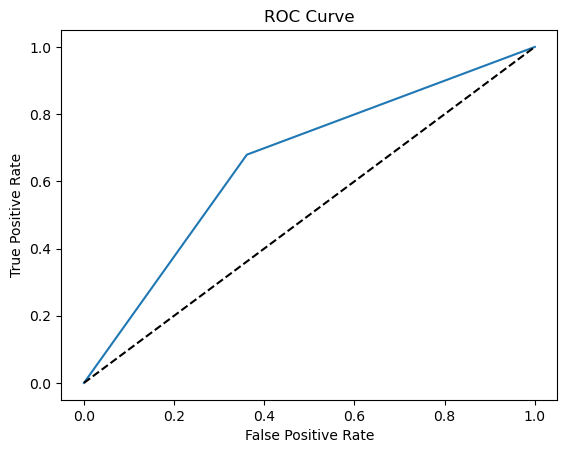

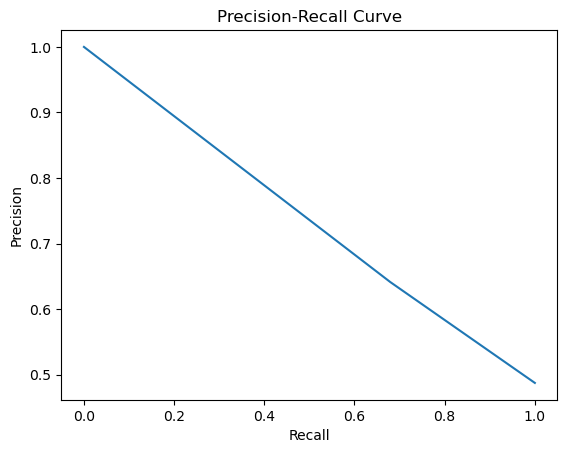

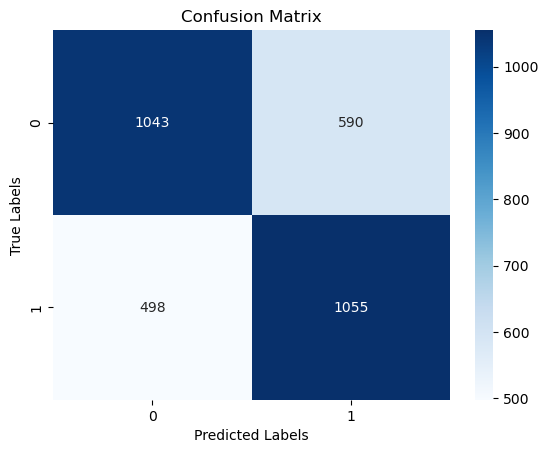

In [63]:
import matplotlib.pyplot as plt
import seaborn as sns


# Plot the ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

# Plot the precision-recall curve
precision, recall, _ = precision_recall_curve(y_test, y_pred)
plt.plot(recall, precision)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.show()

# Plot the confusion matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


### APPROACH 2

In [11]:
### In loop

metrics_data = []

for neighbour in range(1,2037):
    
    ## Train test split
#     x = df.drop('Exited', axis=1)
#     y = df['Exited']

#     x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42, 
#                                                         stratify=df['Exited'])
    
    train, test = train_test_split(df, train_size=0.8, random_state=42, stratify=df.Exited)
    
    x_train = train[['CreditScore', 'Age', 'Tenure', 
                     'Balance', 'NumOfProducts', 'HasCrCard',
                     'IsActiveMember', 'EstimatedSalary']]
    y_train = train['Exited']
    
    x_test = test[['CreditScore', 'Age', 'Tenure', 
                     'Balance', 'NumOfProducts', 'HasCrCard',
                     'IsActiveMember', 'EstimatedSalary']]
    y_test = test['Exited']

    # Apply SMOTE
    sm = SMOTE(random_state=42, k_neighbors=neighbour)

    x_train_new, y_train_new = sm.fit_resample(x_train,y_train)

    # Print the class distribution before and after SMOTE
    # print('Class distribution before SMOTE:\n', y.value_counts())
    # print('Class distribution after SMOTE:\n', y_new.value_counts())

#     df_new = pd.concat([x_train_new, y_train_new], axis=1)

    # print("Shape of x train :: ", x_train.shape)
    # print("Shape of y train :: ", y_train.shape)
    # print("Shape of x test :: ", x_test.shape)
    # print("Shape of y test :: ", y_test.shape)

    ## TRAIN LOGSTIC REGRESSION
    from sklearn.linear_model import LogisticRegression

    log_reg_model = LogisticRegression(random_state=42, max_iter=1000)
    log_reg_model.fit(x_train_new, y_train_new)

    ## Prediction
    y_pred = log_reg_model.predict(x_test)


    ## TRAIN LOGSTIC REGRESSION
    from sklearn.linear_model import LogisticRegression

    log_reg_model = LogisticRegression(random_state=42, max_iter=1000)
    log_reg_model.fit(x_train, y_train)

    ## Prediction
    y_pred = log_reg_model.predict(x_test)

    # Evaluate the model

    test_accuracy = round(accuracy_score(y_test, y_pred), ndigits=4)

    # For class 0
    precision_0 = round(precision_score(y_test, y_pred,pos_label=0), ndigits=4)
    recall_0 = round(recall_score(y_test, y_pred,pos_label=0), ndigits=4)
    f1_0 = round(f1_score(y_test, y_pred, pos_label=0), ndigits=4)

    # For class 1
    precision_1 = round(precision_score(y_test, y_pred,pos_label=1), ndigits=4)
    recall_1 = round(recall_score(y_test, y_pred,pos_label=1), ndigits=4)
    f1_1 = round(f1_score(y_test, y_pred, pos_label=1), ndigits=4)

    # ROC
    roc_auc = round(roc_auc_score(y_test, y_pred), ndigits=4)

    # Calculate true positives, true negatives, false positives, false negatives
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()


    # Perform the Kolmogorov-Smirnov test
#     try:
    ks_stat, p_value = ks_2samp(y_test[y_pred == 0], y_test[y_pred == 1])
    ks_stat = round(ks_stat, ndigits=4)
    p_value = round(p_value, ndigits=4)
#     except:
#         print("KS Test failed")
#         ks_stat = None
#         p_value = None

    y_pred_train = log_reg_model.predict(x_train_new)
    train_accuracy = round(accuracy_score(y_train_new, y_pred_train), ndigits=4)

    metrics_data.append([neighbour, test_accuracy, train_accuracy, 
                         precision_0, recall_0, f1_0,
                         precision_1, recall_1, f1_1, 
                         roc_auc, ks_stat, p_value, 
                         tp, tn, fp, fn])

    # Print the evaluation metrics
    print(f"{neighbour} :: Test Accuracy: {test_accuracy} :: Train Accuracy: {train_accuracy}")
#     print()

#     print("Precision for class 0:", precision_0)
#     print("Recall for class 0:", recall_0)
#     print("F1 Score for class 0:", f1_0)
#     print()

#     print("Precision for class 1:", precision_1)
#     print("Recall for class 1:", recall_1)
#     print("F1 Score for class 1:", f1_1)
#     print()

#     print("ROC AUC Score:", roc_auc)
#     print()

#     # Print the KS statistic and p-value
#     print("Kolmogorov-Smirnov Test:")
#     print("KS statistic:", ks_stat)
#     print("p-value:", p_value)
#     print()


#     # Print the calculated values
#     print("True Positives:", tp)
#     print("True Negatives:", tn)
#     print("False Positives:", fp)
#     print("False Negatives:", fn)
#     print()

#     # Print the classification report
#     print("Classification Report:")
#     print(classification_report(y_test, y_pred))

#     break


1 :: Test Accuracy: 0.792 :: Train Accuracy: 0.5068
2 :: Test Accuracy: 0.792 :: Train Accuracy: 0.5064
3 :: Test Accuracy: 0.792 :: Train Accuracy: 0.5057
4 :: Test Accuracy: 0.792 :: Train Accuracy: 0.506
5 :: Test Accuracy: 0.792 :: Train Accuracy: 0.5053
6 :: Test Accuracy: 0.792 :: Train Accuracy: 0.5053
7 :: Test Accuracy: 0.792 :: Train Accuracy: 0.5055
8 :: Test Accuracy: 0.792 :: Train Accuracy: 0.5053
9 :: Test Accuracy: 0.792 :: Train Accuracy: 0.5053
10 :: Test Accuracy: 0.792 :: Train Accuracy: 0.5062
11 :: Test Accuracy: 0.792 :: Train Accuracy: 0.5049
12 :: Test Accuracy: 0.792 :: Train Accuracy: 0.5066
13 :: Test Accuracy: 0.792 :: Train Accuracy: 0.5068
14 :: Test Accuracy: 0.792 :: Train Accuracy: 0.5057
15 :: Test Accuracy: 0.792 :: Train Accuracy: 0.506
16 :: Test Accuracy: 0.792 :: Train Accuracy: 0.5056
17 :: Test Accuracy: 0.792 :: Train Accuracy: 0.5055
18 :: Test Accuracy: 0.792 :: Train Accuracy: 0.507
19 :: Test Accuracy: 0.792 :: Train Accuracy: 0.5057
20 ::

KeyboardInterrupt: 

In [5]:
metrics_df = pd.DataFrame(data=metrics_data, columns=metrics_data_columns)
metrics_df.to_csv("./smote_k_values_approach_2.csv", header=True, index=False)

In [6]:
metrics_df

,k_neighbour,test_accuracy,train_accuracy,precision_0,recall_0,f1_0,precision_1,recall_1,f1_1,roc_auc,ks_stat,p_value,tp,tn,fp,fn
0,1,0.792,0.5068,0.8038,0.9774,0.8822,0.4286,0.0663,0.1149,0.5219,0.2324,0.0022,27,1557,36,380
1,2,0.792,0.5064,0.8038,0.9774,0.8822,0.4286,0.0663,0.1149,0.5219,0.2324,0.0022,27,1557,36,380
2,3,0.792,0.5057,0.8038,0.9774,0.8822,0.4286,0.0663,0.1149,0.5219,0.2324,0.0022,27,1557,36,380
3,4,0.792,0.5060,0.8038,0.9774,0.8822,0.4286,0.0663,0.1149,0.5219,0.2324,0.0022,27,1557,36,380
4,5,0.792,0.5053,0.8038,0.9774,0.8822,0.4286,0.0663,0.1149,0.5219,0.2324,0.0022,27,1557,36,380
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1624,1625,0.792,0.5060,0.8038,0.9774,0.8822,0.4286,0.0663,0.1149,0.5219,0.2324,0.0022,27,1557,36,380
1625,1626,0.792,0.5049,0.8038,0.9774,0.8822,0.4286,0.0663,0.1149,0.5219,0.2324,0.0022,27,1557,36,380
1626,1627,0.792,0.5064,0.8038,0.9774,0.8822,0.4286,0.0663,0.1149,0.5219,0.2324,0.0022,27,1557,36,380
1627,1628,0.792,0.5061,0.8038,0.9774,0.8822,0.4286,0.0663,0.1149,0.5219,0.2324,0.0022,27,1557,36,380
